In [50]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [51]:
import numpy as np
import pandas as pd

In [165]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [53]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

%ls

 Volume in drive C has no label.
 Volume Serial Number is E895-D4C1

 Directory of C:\Users\Lindsay\UDEN201805DATA1\week11\HW

08/05/2018  05:23 PM    <DIR>          .
08/05/2018  05:23 PM    <DIR>          ..
07/30/2018  09:47 PM    <DIR>          .ipynb_checkpoints
08/05/2018  04:36 PM    <DIR>          .vscode
08/05/2018  04:52 PM    <DIR>          __pycache__
08/05/2018  05:10 PM               205 climate_app.py
08/04/2018  01:45 PM           502,416 climate_starter.ipynb
08/05/2018  05:23 PM           216,101 climate_starter-LNR.ipynb
08/05/2018  04:52 PM               420 dbsetup.py
07/30/2018  11:15 PM    <DIR>          Images
07/28/2018  10:27 AM             5,165 README.md
07/28/2018  10:27 AM    <DIR>          Resources
               5 File(s)        724,307 bytes
               7 Dir(s)  165,919,629,312 bytes free


In [54]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [55]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [56]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [57]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [58]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [168]:
today_date = dt.datetime.today().strftime('%Y-%m-%d')
today_date

'2018-08-05'

In [169]:
from dateutil.relativedelta import relativedelta

twelve_months = dt.datetime.today() + relativedelta(months=-12)
twelve_months = twelve_months.strftime('%Y-%m-%d')
twelve_months

'2017-08-05'

In [170]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Used normal SQL so that I could use the datetime 'now', -12 months formula to get last 12 months
data = engine.execute("""
SELECT date, prcp FROM measurement
WHERE date >= datetime('now', '-12 months')
""")

In [171]:
#Load the query results into a Pandas DataFrame and set the index to the date column.
precip_df = pd.read_sql("""
SELECT date, prcp FROM measurement
WHERE date >= datetime('now', '-12 months')
""", conn)

In [172]:
precip_df.head(10)

,date,prcp
0,2017-08-07,0.00
1,2017-08-08,0.00
2,2017-08-09,0.00
3,2017-08-10,0.00
4,2017-08-11,0.00
5,2017-08-12,0.00
6,2017-08-13,0.00
7,2017-08-14,0.00
8,2017-08-15,0.02
9,2017-08-18,0.00


In [173]:
# Set the index to the date column
precip_df.rename(columns={'prcp': 'precipitation'}, inplace=True)
precip_df.set_index('date', inplace=True)
precip_df.head()

,precipitation
date,
2017-08-07,0.0
2017-08-08,0.0
2017-08-09,0.0
2017-08-10,0.0
2017-08-11,0.0


<IPython.core.display.Javascript object>


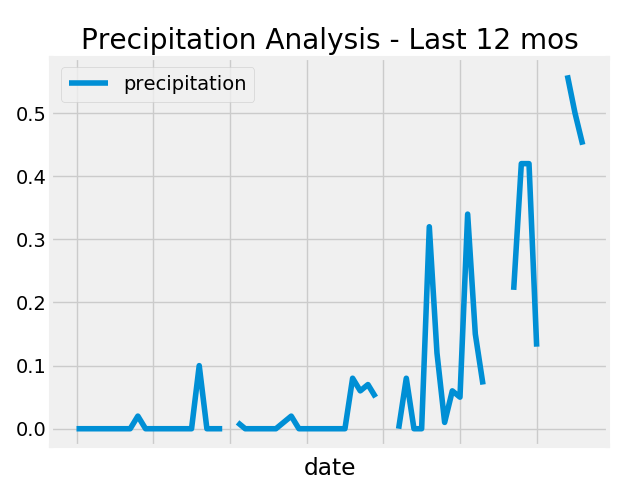

In [174]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot()
plt.title("Precipitation Analysis - Last 12 mos")
plt.savefig("Images/precipitation_analysis.png")
plt.show()

In [175]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,60.000000
mean,0.075833
std,0.140680
min,0.000000
25%,0.000000
50%,0.000000
75%,0.080000
max,0.560000


### Station Analysis

In [176]:
#Design a query to calculate the total number of stations.
station_count = session.query(Station).count()
station_count

9

In [177]:
#Design a query to find the most active stations.
#List the stations and observation counts in descending order
active_stations = session.query(Measurement.station, func.count(Measurement.id)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.id).desc())

for station, count in active_stations:
    print(station, count)

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [36]:
#Which station has the highest number of observations?
mostactive_station = active_stations[0][0]
mostactive_station

'USC00519281'

In [180]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
tobs_calcs = session.query(func.avg(Measurement.tobs).label('avg_temp'), 
              func.min(Measurement.tobs).label('min_temp'),
              func.max(Measurement.tobs).label('max_temp'))\
    .filter(Measurement.station == mostactive_station)
   
tobs_list = {}
tobs_list['data'] = []

for row in tobs_calcs:
    tobs_list['data'].append(
    {"Avg Temp": row.avg_temp, 
     'Min Temp': row.min_temp, 
     "Max Temp": row.max_temp})

tobs_list['data']

[{'Avg Temp': 71.66378066378067, 'Max Temp': 85.0, 'Min Temp': 54.0}]

In [181]:
#Determine when the last observation was taken for station USC00519281 so I can determine the starting point of when I need to pull data
last_obs_date = session.query(Measurement.date).\
filter(Measurement.station == mostactive_station).\
order_by(Measurement.date.desc())

last_obs_date[0]

('2017-08-18')

In [182]:
#Design a query to retrieve the last 12 months of temperature observation data (tobs)
#Filter by the station with the highest number of observations.
#Plot the results as a histogram with bins=12.

temp_obs = session.query(Measurement.date, Measurement.tobs).\
filter(Measurement.station == mostactive_station).\
filter(Measurement.date >= '2016-08-18').\
order_by(Measurement.date).all()

In [183]:
temp_obs_df = pd.DataFrame(temp_obs)
temp_obs_df.head()

,date,tobs
0,2016-08-18,80.0
1,2016-08-19,79.0
2,2016-08-20,81.0
3,2016-08-21,79.0
4,2016-08-22,78.0


<IPython.core.display.Javascript object>


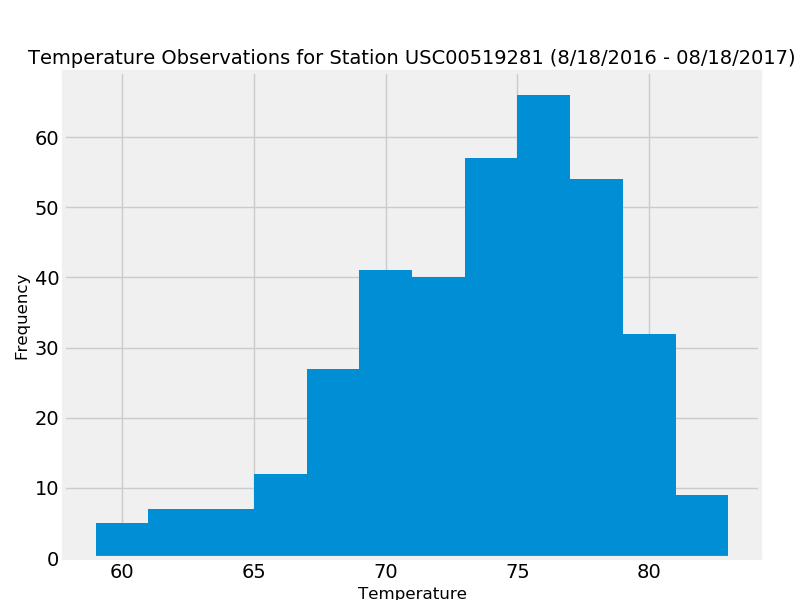

In [184]:
#Plot the results as a histogram with bins=12.
plt.figure(figsize=(8,6))
plt.hist(temp_obs_df['tobs'],12)
plt.title("Temperature Observations for Station {} (8/18/2016 - 08/18/2017)".format(mostactive_station), fontsize=14)
plt.ylabel("Frequency", fontsize=12)
plt.xlabel("Temperature", fontsize=12)
plt.savefig("Images/TempObs.png")
plt.show()